In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

fatal: destination path 'adahessian' already exists and is not an empty directory.


In [39]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [40]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer_lessold import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main function

In [41]:
def run(num_epoch = 100, is_renormalized=True, make_small=False):

  print(f"### Starting run ### \n   with num_epoch={num_epoch}, is_renormalized={is_renormalized}, make_small={make_small}")

  if is_renormalized:
    std = [0.0001,1,10000]
  else:
    std = [1,1,1]
  print(f"std = {std} ")
  renormalize = transforms.Normalize([0,0,0], std, inplace=False)
  transform =  transforms.Compose([ToTensor(),renormalize])
  train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=transform)
  test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=transform)



  # Use a small subset of the data
  # only error: 'Subset' object has no attribute 'targets'
  if make_small: # put False if don't want it
    rng = np.random.default_rng()

    indices = rng.choice(len(train_data), 1000, replace=False)
    train_data = torch.utils.data.Subset(train_data, indices)

    indices = rng.choice(len(test_data), 200, replace=False)
    test_data = torch.utils.data.Subset(test_data, indices)
    labels = np.array([0,1,2,3,4,5,6,7,8,9])
  else:
      labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets, like 'Subset' objects
  print("labels=", labels)



  batch_size = 256
  trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
  testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )
  print(f"Using {device} device")

  #device = xm.xla_device()



  req_grad = True
  seed = 100
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # Initialize the model for this run
  model, input_size = initialize_model(use_pretrained=False)



  # Send the model to GPU

  model = model.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model.parameters()
  #print("Params to learn:")
  if req_grad:
      params_to_update = []
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              #print("\t",name)
  else:
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              #print("\t",name)
              pass


  lr=0.15 # default: 0.15
  betas = (0.9, 0.999) # default: (0.9, 0.999)
  weight_decay = 0.0005 # default: 0
  hessian_power = 1 # default: 1
  momentum = 0.95 # 0.95

  #optimizer_name = 'adahessian'
  optimizer_name = 'adahessian' # 'adahessian' only

  print(f"Parameters of {optimizer_name}: \n    lr={lr}, betas={betas}, weight_decay={weight_decay}, hessian_power={hessian_power}")


  if optimizer_name == 'adahessian':
    optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
  elif optimizer_name == "adam":
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()

  scheduler_name = "multilr"
  scheduler = None
  if scheduler_name == "multilr":
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 120], gamma=0.1)
  if is_renormalized:
    case_name = "renormalized"
  else:
    case_name = "unrenormalized"
  path= f'./drive/MyDrive/Opti-ML/model_weights/{case_name}_model_{optimizer_name}.pt'
  train_loss_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_train_loss_{optimizer_name}.txt'
  train_acc_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_train_acc_{optimizer_name}.txt'
  test_loss_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_test_loss_{optimizer_name}.txt'
  test_acc_path = f'./drive/MyDrive/Opti-ML/loss_and_acc/{case_name}_test_acc_{optimizer_name}.txt'



  #check the warning, nothing more on the adahessian git
  # model,traindataset,batch_size,kfold,criterion,optimizer_name,scheduler,num_epoch,savepath,use_pretrained,lr,betas,momentum,weight_decay,hessian_power,device='cpu'
  train_loss, list_testloss, lowest_loss, model_weights, train_acc, test_acc = train_and_test(model,trainloader,testloader,criterion,optimizer,scheduler,num_epoch,path,device)
  with open(train_loss_path, 'w') as fp:
      for item in train_loss:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(train_acc_path, 'w') as fp:
      for item in train_acc:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(test_loss_path, 'w') as fp:
      for item in list_testloss:
          # write each item on a new line
          fp.write("%s\n" % item)
  with open(test_acc_path, 'w') as fp:
      for item in test_acc:
          # write each item on a new line
          fp.write("%s\n" % item)

  testloader = DataLoader(test_data, batch_size=1, shuffle=True)
  accuracy = test_model(model,testloader,path,device)
  print(f"Accuracy={accuracy}")

  if is_renormalized:
    word = ""
  else:
    word = " not"

  plt.plot(train_loss,'.-')
  plt.plot(list_testloss,'.-')
  plt.title(f"Evolution of loss during training,{word} normalized")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(["train","test"])
  plt.savefig(f"drive/MyDrive/Opti-ML/graphics/{case_name}_{optimizer_name}_loss.pdf")

# Runs

In [42]:
num_epoch=3

### Starting run ### 
   with num_epoch=3, is_renormalized=True, make_small=False
std = [0.0001, 1, 10000] 
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


labels= [0 1 2 3 4 5 6 7 8 9]
Using cuda device
Parameters of adahessian: 
    lr=0.15, betas=(0.9, 0.999), weight_decay=0.0005, hessian_power=1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0/2
----------
Train Loss: 1.7595
Test Loss: 1.6239


 33%|███▎      | 1/3 [01:11<02:23, 71.54s/it]

Train accuracy: 0.4494
Test accuracy: 0.4332
Epoch 1/2
----------
Train Loss: 1.2347
Test Loss: 1.2007


 67%|██████▋   | 2/3 [02:22<01:11, 71.37s/it]

Train accuracy: 0.6194
Test accuracy: 0.5788
Epoch 2/2
----------
Train Loss: 1.0207
Test Loss: 1.4042


100%|██████████| 3/3 [03:34<00:00, 71.38s/it]

Train accuracy: 0.5936
Test accuracy: 0.5506


Accuracy=0.5506


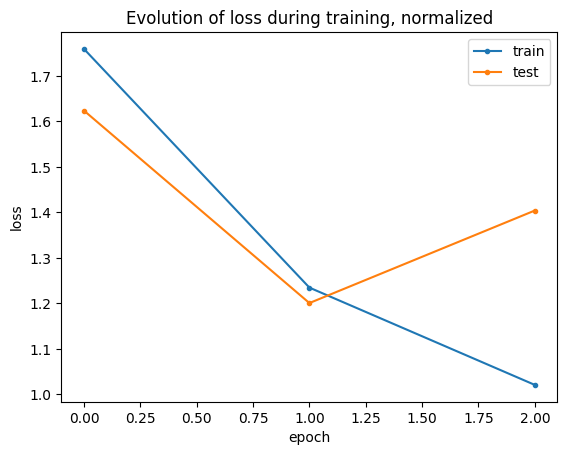

In [43]:
run(num_epoch = num_epoch, is_renormalized=True)

In [ ]:
run(num_epoch = num_epoch, is_renormalized=False)

### Starting run ### 
   with num_epoch=3, is_renormalized=False, make_small=False
std = [1, 1, 1] 
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


labels= [0 1 2 3 4 5 6 7 8 9]
Using cuda device
Parameters of adahessian: 
    lr=0.15, betas=(0.9, 0.999), weight_decay=0.0005, hessian_power=1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0/2
----------
Train Loss: 2.6048
Test Loss: 1.5682


 33%|███▎      | 1/3 [01:11<02:22, 71.12s/it]

Train accuracy: 0.4594
Test accuracy: 0.4395
Epoch 1/2
----------
Train Loss: 1.3927
Test Loss: 1.3746


 67%|██████▋   | 2/3 [02:21<01:10, 70.78s/it]

Train accuracy: 0.5507
Test accuracy: 0.5090
Epoch 2/2
----------
